# Homework 2 Part 2 - Model Based Reinforcement Learning

***

Written by Albert Wilcox

In this homework, you'll implement [PETS](https://arxiv.org/abs/1805.12114), a popular model for simple MBRL tasks.


First, in the top right corner make sure you're connected to a T4 GPU since those are the only runtimes we tested these instructions on.

Next, Upload the folder 'hw2' from the Git repo into your Google Drive.

Finally, ensure that the paths in the following cell are correct and run the following cells to set up your Colab environment and install the necessary requirements. Note that for Colab you do this instead of dealing with the conda environment.

In [13]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/hw2')
sys.path.append('/content/drive/MyDrive/hw2')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libglew-dev is already the newest version (2.2.0-4).
libgl1-mesa-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.2).
libosmesa6-dev is already the newest version (23.2.1-1ubuntu3.1~22.04.2).
software-properties-common is already the newest version (0.99.22.9).
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
patchelf is already the newest version (0.14.3-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
  Cloning https://github.com/Farama-Foundation/d4rl (to revision master) to /tmp/pip-install-earyn_4s/d4rl_1f0c5359f25f4d2d80334bafc997a807
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/d4rl /tmp/pip-install-earyn_4s/d4rl_1f0c5359f25f4d

Now run the following cell. Everything should import correctly.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import einops

import gym
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm, trange

from typing import Tuple, Optional

from src.utils import (
    get_device,
    set_seed,
    demo_policy,
    save_frames_as_gif
)
# Do not remove the following import
import src.cartpole_env
from src.mpc import MPC
from src.mbrl_utils import sample_rollout
from src.cartpole_env import CartpoleConfigModule
from src.mbrl_sampler import MBRLSampler

plt.ion()

In [16]:
SEED: int = 42
ENVIRONMENT_NAME: str='MBRLCartpole-v0'

# torch related defaults
DEVICE = get_device()
torch.set_default_dtype(torch.float32)

# Use random seeds for reproducibility
set_seed(SEED)

2024-11-11 20:22:53.869 | INFO     | src.utils:get_device:52 - Using cuda device.
2024-11-11 20:22:53.876 | INFO     | src.utils:set_seed:38 - Random seed set as 42.


As before, we start by initializing the environment and printing some useful information.

In [17]:
env = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
action_dimension = env.action_space.shape[0]
state_dimension = env.observation_space.shape[0]

logger.info(f'Action Dimension: {action_dimension}')
logger.info(f'Action High: {env.action_space.high}')
logger.info(f'Action Low: {env.action_space.low}')
logger.info(f'State Dimension: {state_dimension}')

2024-11-11 20:22:56.257 | INFO     | __main__:<cell line: 7>:7 - Action Dimension: 1
2024-11-11 20:22:56.258 | INFO     | __main__:<cell line: 8>:8 - Action High: [3.]
2024-11-11 20:22:56.261 | INFO     | __main__:<cell line: 9>:9 - Action Low: [-3.]
2024-11-11 20:22:56.263 | INFO     | __main__:<cell line: 10>:10 - State Dimension: 4


### Part 1 - PETS

In this part you'll implement the PETS (Chua et al.) dynamics model and use it for model-based control (MPC). There are several important components of this pipeline:
 * The dynamics model, discussed in more detail in Chua et al, learns to predict the next state $s_{t+1}$ conditioned on the current state-action pair $(s_t, a_t)$.
 * The cost function outputs the cost of a planned state. In the case of this environment, we provide a ground truth cost function (negative velocity), but in more complicated environments where no ground truth cost function is available it is common to learn it.
 * Cross entropy method (CEM) is a gradient-free evolutionary optimizer. We use it to optimize sequences of actions, and evaluate these sequences of actions by predicting future states after rolling out the planned actions and computing the total cost of the predicted rollout under the cost function.

The first step is to set up our probabilistic dynamics model. As described in Chua et al, this should take in a state and action and output `mean` and `log_std` for a Gaussian distribution over possible future states.

In [18]:
from src.networks import network

class DynamicsModel(nn.Module):
    def __init__(self,
                 state_dimension: int,
                 action_dimension: int,
                 min_log_std: float = -5,
                 max_log_std: float = 1,
                 ):
        super(DynamicsModel, self).__init__()

        # TODO: fill in the parameters to initialize the prediction network
        # Network to predict next state mean and log standard deviation
        input_dim = state_dimension + action_dimension
        hidden_dim = 200  # Example hidden dimension; adjust based on need
        output_dim = state_dimension  # Output dimensions for mean prediction

        # Define the layers for the network
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean_layer = nn.Linear(hidden_dim, output_dim)
        self.log_std_layer = nn.Linear(hidden_dim, output_dim)

        # Log std bounds
        self.min_log_std = min_log_std
        self.max_log_std = max_log_std

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the dynamics network. Should return mean and log_std of the next state distribution

        Args:
            state (torch.Tensor): The input state.
            action (torch.Tensor): The input action.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The tuple (mean, log_std) of the distribution
        """

        # TODO: predict the mean and log_std of the next state distribution as described above
        # Concatenate state and action
        x = torch.cat([state, action], dim=-1)

        # Pass through network layers with activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Predict mean and log_std
        mean = self.mean_layer(x)
        log_std = self.log_std_layer(x).clamp(self.min_log_std, self.max_log_std)

        return mean, log_std


The next step is to create an ensemble of dynamics models. There are better ways to implement this, but for the purposes of this assignment we'll simply maintain a list of models and loop through them at inference time. If you have access to a GPU and are interested in speeding up your implementation, you might want to check out https://pytorch.org/tutorials/intermediate/ensembling.html.

There are several ways to handle data for ensembles, such as partitioning the dataset or training each network on different minibatches from the same dataset. In this assignment, we randomly sample `n_ensemble` subsets of the data with replacement. For each epoch, we train each member of the ensemble on a different subset and then shuffle the subsets. To better understand this, please refer to `src/mbrl_sampler.py`.

TODOs for this section:
 * Fill in the `forward` function of the dynamics model to predict the mean and log_std from each member of the ensemble for a single batch of states and actions. This is for use during training
 * Fill in the `compute_cost` function which takes in a single state and a batch of action trajectory candidates and computes the expected cost for each one by rolling out the dynamics model. You should do this using the TS-1 algorithm from Chua et al, meaning for each step you randomly sample a dynamics model from the ensemble. Note the parameter `n_particles`. For each action trajectory candidate, you should sample `n_particles` trajectories and compute the mean between their costs.
 * Note: the `compute_cost` function will involve creating some large tensors. For tensors with many dimensions to keep track of, I would highly recommend using the `einops` library for rearranging / tiling / etc.

In [23]:
class EnsembleDynamicsModel(nn.Module):
    def __init__(self, state_dimension: int, action_dimension: int, n_ensemble: int):
        super(EnsembleDynamicsModel, self).__init__()
        self.num_nets = n_ensemble

        # TODO: initialize an ensemble of dynamics models
        # Hint: You should store the models in an nn.ModuleList so that they appear when we do dynamics_model.parameters()
        # Initialize an ensemble of dynamics models
        self.models = nn.ModuleList([
            DynamicsModel(state_dimension, action_dimension) for _ in range(n_ensemble)
        ])

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the dynamics network. Should return mean and log_std of the next state distribution for each model in the ensemble

        Args:
            state (torch.Tensor): The input state, shape (B, n_ensemble, S)
            action (torch.Tensor): The input action, shape (B, n_ensemble, A)

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: The tuple (mean, log_std) of the distributions where each have shape (B, n_ensemble, S)
        """

        # TODO: predict the next state as described above
        means = []
        log_stds = []

        for model in self.models:
            mean, log_std = model(state, action)
            means.append(mean)
            log_stds.append(log_std)

        # Stack means and log_stds along a new dimension to match ensemble size
        means = torch.stack(means, dim=1)  # Shape: (B, n_ensemble, S)
        log_stds = torch.stack(log_stds, dim=1)  # Shape: (B, n_ensemble, S)
        return mean, log_std

    def compute_cost(
            self,
            state: torch.Tensor,
            actions: torch.Tensor,
            obs_cost_fn,
            act_cost_fn,
            n_particles: int = 20,
        ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Given a state and a

        Args:
            state (torch.Tensor): The input state, shape (S,)
            actions (torch.Tensor): The action sequence candidates, shape (N, H, A)
            obs_cost_fn: A function which takes in a batch of states and returns the cost of each one
            act_cost_fn: A function which takes in a batch of actions and returns the cost of each one
            n_particles (int): how many particles to sample for each action sequence

        Returns:
            torch.Tensor: Expected cost for each action candidate, shape (N,)
        """
        n_candidates, horizon, _ = actions.shape

        # TODO: predict the trajectory using the TS-1 algorithm from Chua et al
        # Hint: You may have issues with NaN values. To deal with this, use the reparameterization trick
        #       to sample and then replace NaN costs with a high number

        costs = torch.zeros(n_candidates, device=state.device)

        # Expand state for particle simulations and initialize particle states
        particle_states = einops.repeat(state, 's -> p n s', p=n_particles, n=n_candidates)


        for t in range(horizon):
            current_actions = actions[:, t, :].unsqueeze(0).expand(n_particles, -1, -1)
            step_costs = torch.zeros(n_candidates, device=state.device)

            # Sample a model from the ensemble for each particle
            chosen_models = torch.randint(0, self.num_nets, (n_particles,), device=state.device)
            next_means = []
            next_log_stds = []

            # Compute mean and log_std for each model in the sample
            for i, model_idx in enumerate(chosen_models):
                mean, log_std = self.models[model_idx](particle_states[i], current_actions[i])
                next_means.append(mean)
                next_log_stds.append(log_std)

            # Stack means and log_stds, then sample next state
            next_means = torch.stack(next_means, dim=0)
            next_log_stds = torch.stack(next_log_stds, dim=0)
            stds = next_log_stds.exp()

            # Sample from normal distribution (reparameterization trick)
            noise = torch.randn_like(next_means)
            next_states = next_means + noise * stds

            # Update particle states
            particle_states = next_states

            # Calculate costs using obs_cost_fn and act_cost_fn
            obs_cost = obs_cost_fn(particle_states)
            act_cost = act_cost_fn(current_actions)
            step_costs = obs_cost + act_cost

            # Replace any NaN costs with a high cost
            step_costs = torch.where(torch.isnan(step_costs), torch.tensor(1e6, device=step_costs.device), step_costs)

            # Average over particles and add to total costs
            costs += step_costs.mean(dim=0)

        return costs


Now that we've set up everything, the last step is to train our model. In the following block we provide some hyperparameters, the ground truth cost functions, and the skeleton of the training loop. You'll need to implement the loss function yourself.

Unfortunately MPC is quite slow to run, especially on a CPU. Thus, we've provided you an offline dataset so that you don't need to run the MPC policy to collect online data. The dataset should be sufficient to achieve a reward greater than 150 with a correct implementation.

Note: Our implementation achieved a validation loss <0.1.

The hyperparameters we provide should work well enough, but if you have access to a GPU you can improve performance by increasing `n_particles`, `popsize` and `num_elites`.

In [24]:
################################## Hyper-parameters #########################################

EPOCHS = 10
EVAL_FREQ = 30
TASK_HORIZON = 200

plan_hor = 25
n_particles = 10
batch_size = 32
n_ensemble = 5
maxiters = 5
popsize = 100
num_elites = 10

################################### Cost Functions ###########################################

sampler = MBRLSampler(torch.load('data.pkl'), n_ensemble, batch_size, DEVICE)

# To make things faster for you we're providing an offline dataset that should be sufficient
rollouts = torch.load('data.pkl')
all_obs = np.concatenate([rollout['obs'] for rollout in rollouts], axis=0)
all_act = np.concatenate([rollout['act'] for rollout in rollouts], axis=0)
all_next_obs = np.concatenate([rollout['next_obs'] for rollout in rollouts], axis=0)

config = CartpoleConfigModule(DEVICE)
dynamics_model = EnsembleDynamicsModel(state_dimension, action_dimension, n_ensemble).to(DEVICE)
optimizer = Adam(dynamics_model.parameters(), 1e-3, weight_decay=1e-4)
policy = MPC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    obs_cost_fn=config.obs_cost_fn,
    act_cost_fn=config.ac_cost_fn,
    dynamics_model=dynamics_model,
    plan_hor=plan_hor,
    n_particles=n_particles,
    max_iters=maxiters,
    popsize=popsize,
    num_elites=num_elites,
    alpha=0.1,
    device=DEVICE
)

data_len = all_obs.shape[0]

epoch_range = trange(EPOCHS, unit="epoch(s)", desc="Network training")
num_batch = int(np.ceil(data_len / batch_size))
result = None
rews = []

for epoch in epoch_range:

    for obs, act, next_obs in sampler:

        # TODO: compute NLL loss and update the dynamics model
        # Forward pass through each model in the ensemble
        means, log_stds = dynamics_model(obs, act)

        # Compute NLL loss
        stds = log_stds.exp()
        nll_loss = ((next_obs - means) ** 2) / (2 * stds ** 2) + log_stds
        nll_loss = nll_loss.mean()  # Mean over all elements for scalar loss

        # Backward pass and optimizer step
        optimizer.zero_grad()
        nll_loss.backward()
        optimizer.step()

    # Compute validation MSE loss
    # Note: this is a different loss function than the one you should implement to update the model
    val_obs, val_act, val_next_obs = sampler.get_val_data()
    mean, _ = dynamics_model(val_obs, val_act)
    mse_losses = ((mean - val_next_obs) ** 2).mean()

    epoch_range.set_postfix({
        "Training loss": mse_losses.item(),
        'Reward': result
    })

    # Sample an eval rollout. Note: If you are not using a GPU you should comment this out and only run eval once
    if (epoch + 1) % EVAL_FREQ == 0:
        info = sample_rollout(
            env,
            TASK_HORIZON,
            policy=policy,
        )
        result = info['reward_sum']
        rews.append(result)

torch.save(dynamics_model.state_dict(), 'pets_checkpoint.pth')


<ipython-input-24-cdc90027d6bf>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sampler = MBRLSampler(torch.load('data.pkl'), n_ensemble, batch_size, DEVICE)
<ipython-inpu

Now that you've finished training your dynamics model we can visualize our MPC policy and print out the final reward.

Note: If you're running this on a CPU it will likely be quite slow. I would suggest visualizing a much shorter episode and making sure that the policy looks right before running the full 200 step eval.

<ipython-input-25-11d3dcc07089>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dynamics_model.load_state_dict(torch.load('pets_checkpoint.pth'))
100%|██████████| 200/200 [

Total Reward: -0.605660819579542


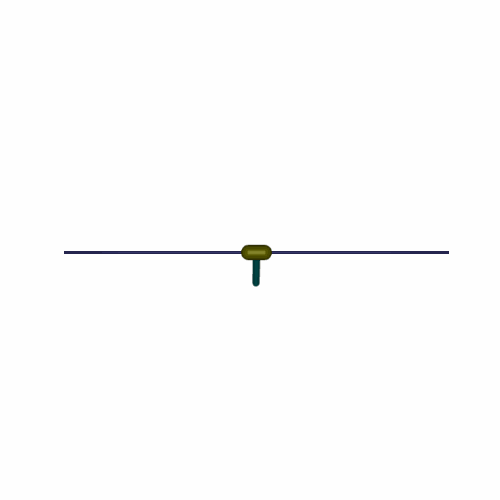

In [25]:
dynamics_model.load_state_dict(torch.load('pets_checkpoint.pth'))
dynamics_model = dynamics_model.to(DEVICE)
frames, total_reward = demo_policy(policy, environment_name=ENVIRONMENT_NAME, steps=200)
gif_path = save_frames_as_gif(frames, method_name='pets')
print('Total Reward:', total_reward)
Image(open(gif_path,'rb').read())

Congrats on finishing the MBRL portion of Assignment 2! Hopefully you enjoyed yourself. Make sure that the visualizations are showing, an eval with a reward greater than 150 is showing above, and that the `pets_policy.gif` is present in the outputs folder.

When you're done: export this notebook as an **HTML file** for final submission.